<a href="https://colab.research.google.com/github/veotani/ml-univsersity-course-ms-3sem/blob/master/Conclusion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import pandas as pd
import numpy as np
import pickle

from zipfile import ZipFile
from os import listdir
from scipy.sparse import csr_matrix, find
from scipy.sparse.linalg import svds
from matplotlib import pyplot
from tqdm import tqdm_notebook
from sklearn.neighbors import NearestNeighbors

In [0]:
# # Считываем данные
# INPUT_FILES_PATH = 'drive/My Drive/study-science/Интеллектуальный анализ данных/'

# users =   [] # user ids   translated into row indeces (which are 1 less than id)
# movies =  [] # movies ids translated into col indeces (which are 1 less than id)
# ratings = [] # rating[k] = (rating that users[k] user gave to movies[k] movie)

# new_user_ids = dict()
# users_count = 0

# for file_part in range(1, 5): # the training data is splited into 4 parts
#   filename = INPUT_FILES_PATH + f'combined_data_{file_part}.txt'
#   with open(filename) as f:
#     for line in f:
#       if ':' in line:
#         current_movie = int(line.split(':')[0]) - 1
#         continue
#       user, rating, _ = line.split(',')
#       if user in new_user_ids:
#         current_user = new_user_ids[user]
#       else:
#         new_user_ids[user] = users_count
#         current_user = users_count
#         users_count += 1
#       current_rating = int(rating)
#       users.append(current_user)
#       movies.append(current_movie)
#       ratings.append(current_rating)

# # Возьмём 10% датасета
# max_user_id = ((max(users) + 1)) // 10
# max_movie_id = ((max(movies)) + 1) // 10

# users_subset = []
# movies_subset = []
# ratings_subset = []

# for i in range(len(users)):
#   if users[i] < max_user_id and movies[i] < max_movie_id:
#     users_subset.append(users[i])
#     movies_subset.append(movies[i])
#     ratings_subset.append(ratings[i])

# # Удаляем полные данные
# del users
# del movies
# del ratings

# # Разделяем на тестовые и тренировочные
# test_users = [users_subset[i] for i in range(len(users_subset)) if i % 5 == 1]
# train_users = [users_subset[i] for i in range(len(users_subset)) if i % 5 != 1]
# del users_subset

# test_movies = [movies_subset[i] for i in range(len(movies_subset)) if i % 5 == 1]
# train_movies = [movies_subset[i] for i in range(len(movies_subset)) if i % 5 != 1]
# del movies_subset

# test_ratings = [ratings_subset[i] for i in range(len(ratings_subset)) if i % 5 == 1]
# train_ratings = [ratings_subset[i] for i in range(len(ratings_subset)) if i % 5 != 1]
# del ratings_subset

# ratings_matrix = csr_matrix((train_ratings, (train_movies, train_users)))
# del train_ratings
# del train_movies
# del train_users

In [0]:
# with open(INPUT_FILES_PATH + 'bigmatrix.pickle', mode='wb+') as f:
#   pickle.dump(ratings_matrix, f)
# with open(INPUT_FILES_PATH + 'test_users.pickle', mode='wb+') as f:
#   pickle.dump(test_users, f)
# with open(INPUT_FILES_PATH + 'test_movies.pickle', mode='wb+') as f:
#   pickle.dump(test_movies, f)
# with open(INPUT_FILES_PATH + 'test_ratings.pickle', mode='wb+') as f:
#   pickle.dump(test_ratings, f)

In [0]:
with open(INPUT_FILES_PATH + 'bigmatrix.pickle', mode='rb') as f:
  ratings_matrix = pickle.load(f)
with open(INPUT_FILES_PATH + 'test_users.pickle', mode='rb') as f:
  test_users = pickle.load(f)
with open(INPUT_FILES_PATH + 'test_movies.pickle', mode='rb') as f:
  test_movies = pickle.load(f)
with open(INPUT_FILES_PATH + 'test_ratings.pickle', mode='rb') as f:
  test_ratings = pickle.load(f)

# Обоснование результатов

Самая маленькая погрешность достигается в результате присваивания средних рейтингов по столбцам и строкам. Среднее значение не является хорошим способом угадывания неизвестных значений для выборок с высоким среднеквадратичным отклонением. В нашем случае среднеквадратичное отклонение принимает значения на отрезке [0, 2.5]. Посмотрим на значения отклонения для двух способов:

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


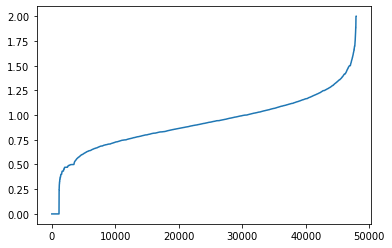

In [51]:
means = np.divide(ratings_matrix.sum(axis=0), (ratings_matrix!=0).astype('i8').sum(axis=0))
disp = ratings_matrix - means
A = ratings_matrix.toarray()
disp = np.multiply(np.array(disp).astype('f'), (A>0).astype('f'))
disp = np.multiply(disp, disp)
disp = np.divide(disp, (ratings_matrix!=0).astype('i8').sum(axis=0)).sum(axis=0)
std_div = np.sqrt(disp)
pyplot.plot(np.sort(np.array(std_div)[0]))

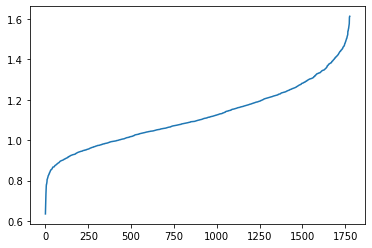

In [64]:
means = np.divide(ratings_matrix.sum(axis=1), (ratings_matrix!=0).astype('i8').sum(axis=1))
disp = ratings_matrix - means
A = ratings_matrix.toarray()
disp = np.multiply(np.array(disp).astype('f'), (A>0).astype('f'))
disp = np.multiply(disp, disp)
disp = np.divide(disp, (ratings_matrix!=0).astype('i8').sum(axis=1)).sum(axis=1)
std_div = np.sqrt(disp)
pyplot.plot(np.sort(np.array(std_div).T[0]))

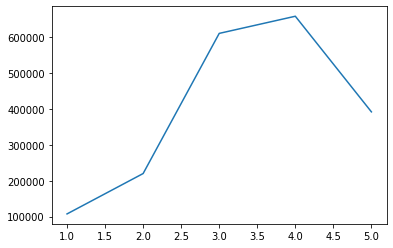

In [73]:
count_ratings = dict()
for i in range(1, 6):
  count_ratings[i] = np.sum((A==i).astype('i8'))
pyplot.plot(list(count_ratings.keys()), list(count_ratings.values()))

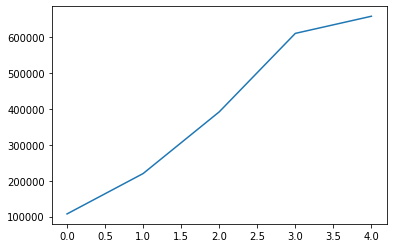

In [75]:
pyplot.plot(list(sorted(count_ratings.values())))

Как видно из графиков, оценки не распределены равномерно. Заметно, что большинтсво оценок являются "4", затем "3" и "5" и только уже после них самые низкие оценки с сильным отставанием. Поэтому ставить 4-ки пустым клеткам уже будет эффективным способом:

In [78]:
A_filled_with_fours = A + (A==0).astype('i8') * 4
error = 0
for i in range(len(test_users)):
  error += abs(A_filled_with_fours[test_movies[i], test_users[i]] - test_ratings[i])
error/len(test_users)

0.8901173843507649

Можно сделать вывод, что по этим данным лучше всего проставлять средние значения, так как они не имеют сильного среднеквадратичного отклонения (в обоих случаях 80% значений имеют стандартное отклонение меньше, чем в два раза меньше от максимального).